## SWE analysis

In [1]:
from osgeo import gdal
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import pandas as pd
import fiona
import os
import glob
from scipy import sparse
import seaborn as sns
from math import radians
import plotly.graph_objects as go
%matplotlib inline

,wshed,phase,l_ci,multiplier,h_ci,resolution,date,color
0,EGM,P01,0.348,0.38,0.415,1,March 11 2021,0
1,EGM,P02,0.400,0.42,0.432,1,April 5 2021,1
2,EGM,P03,0.476,0.50,0.519,1,April 20 2021,2
3,EGM,P04,0.512,0.53,0.547,1,May 15 2021,3
4,EGM,P05,0.554,0.57,0.589,1,June 21 2021,4


In [3]:
#calculate the low and high confidence interval multipliers
def swe_multiplier(meta_df, phase,parameter):
    parameter = meta_df.loc[meta_df['phase']== phase, parameter].item()
    return parameter

In [102]:
#extract the cooridnates of the sub basin shapefile 
def coords (basin_directory):
    with fiona.open(basin_directory) as shapefile:
        #print(shapefile)
        for feature in shapefile:
            shapes = [feature["geometry"]]
    return shapes

In [103]:
#call function to mask the rasters to basin shapefile
def open_masked_raster_array(tif):
    with rio.open(tif) as src:
        print("opening raster..")
        #identify no data value
        nodataval = src.nodatavals
        nodataval=nodataval[0]
        
        raster_image, raster_transform = rio.mask.mask(src, mask_coords, crop=True)
        raster_image = raster_image[0,:,:]
        #change the no data value to -9999.0
        raster_image[raster_image == nodataval] = -9999.0
        #unravel the array
        raster_image_unravel = np.ravel(raster_image)
        ("Unravelling raster to 1D array..")
        #print(str(tif) + "Array length:" + str(np.shape(raster_image_unravel)))
        return raster_image_unravel

In [6]:
#convert the raster arrays inro a dataframe 
def array_to_df(be_dem_ravel,aspect_ravel,snow_depth_ravel):
    #combine unravelled arrays into a dataframe
    df = pd.DataFrame({"Elev": be_dem_ravel,"Asp": aspect_ravel, "SD": snow_depth_ravel})
    #print(df[df.columns[0]].count())
    #print(df[df.columns[1]].count())
    #print(df[df.columns[2]].count())
    
    #dropping any rows which have at least one no data value
    df = df[(df.Elev != -9999.0) & (df.Asp != -9999.0) & (df.SD != -9999.0)]
    df = df.reset_index(drop=True)
    df['zbin'] = round(df["Elev"], -2)
    df["Asp"]= round(df["Asp"])
    
    #calculate aspect
    conditions_asp = [
        df["Asp"] == -1,
        df["Asp"] <= 22.5,
        df["Asp"] <= 67.5,
        df["Asp"] <= 112.5,
        df["Asp"] <= 157.5,
        df["Asp"] <= 202.5,
        df["Asp"] <= 247.5,
        df["Asp"] <= 292.5,
        df["Asp"] <= 337.5,
        df["Asp"] <= 360]
    
    values_asp = ["Flat", "North", "Northeast", "East", "Southeast", "South", "Southwest", "West", "Northwest", "North"]
    df["Aspect"] = np.select(conditions_asp, values_asp)   
    return df

In [7]:
def swe_calc(df,meta_df,phase):
    print("calculating SWE..")
    
    #call function to calculate swe multipliers
    l_ci = swe_multiplier(meta_df,phase,"l_ci")
    h_ci = swe_multiplier(meta_df,phase,"h_ci")
    multiplier = swe_multiplier(meta_df,phase,"multiplier")
    resolution = swe_multiplier(meta_df,phase,"resolution")
    
    df["swe"]= df["SD"]*(multiplier)
    df["count"]=1
    df["swe_mm"]= df["swe"]*1000
    df["swe_lm"]=(df["SD"]*l_ci)*1000
    df["swe_hm"]=(df["SD"]*h_ci)*1000
    df["water_vol"]= df["swe"]*(resolution*resolution)
    df["lower_wv"]=df["water_vol"]*(l_ci/multiplier)
    df["upper_wv"]=df["water_vol"]*(h_ci/multiplier)
    
    return df

In [73]:
#Create dataframes for Average SWE by elevation and sum of water volume by elevation, parameter can be either zbin or aspect
def stats(parameter,basin_name,df,wshed,phase):
    print("calculating " + str(parameter) + " table.....")
    avg_swe = round(df.groupby(by=[parameter],as_index=True)[["swe_mm","swe_lm", "swe_hm"]].mean(),2)
    avg_wv = round(df.groupby(by=[parameter],as_index=True)[["water_vol", "lower_wv", "upper_wv"]].sum(),2)
    count = df.groupby(by=[parameter], as_index=True)[["water_vol"]].count()
    count.columns = ["count"]
    
    #join grouped tables together
    merged=pd.concat([avg_swe,avg_wv,count],axis=1)
    #Add column for phase
    merged["Phase"]= phase
    merged["Basin"]= basin_name
    #if parmeter is for the polar plots
    #if parameter == "Asp":
        #return merged
    #else:
        #Drop values which have less than 100 entries
        #merged = merged[merged["count"]>100]
        #return merged
    merged = merged[merged["count"]>100]
    return merged

In [87]:
# Group data frame and drop rows if not meeting minimum threshold
def pivot_heatmap(df,watershed,wshed,phase,basin_name):
    #group the data by zbin and aspect
    groupby = df.groupby(["zbin", "Aspect"],as_index=False).agg({"water_vol":["count","sum"]})
    
    # change column names
    groupby.columns = ["zbin", "Aspect", "count", "water_vol"]
    
    # drop rows which have a count of less than 10
    groupby = groupby[groupby["count"]>10]
    
    # change column names
    groupby.columns = ["zbin", "Aspect", "Count", "water_vol"]
    
    #Set the aspect order
    all_aspects = ["North", "Northeast", "East", "Southeast", "South", "Southwest", "West", "Northwest"]
    
    #create cross tab table formatted as a heat map
    hmap = pd.crosstab(
          index=groupby['zbin'], columns=groupby['Aspect'],aggfunc="sum",
         values=groupby["water_vol"],margins=False).fillna(0).round(0)
    
    #reorder the aspects for consistent format
    hmap = hmap[all_aspects]
    
    #plot the heatmap
    plt.figure(figsize=(16,5))
    plt.title("{} Total Water Volume [m\u00b3] \n Phase {}, {} basin".format(watershed,phase[2:],basin_name)) 
    sns.heatmap(hmap,
            cmap="YlGnBu", annot=True, cbar=True,fmt='g')
    plt.ylabel('Elevation [m - ellipsoid]') # y-axis label
    plt.savefig("outputs/{}_{}_{}_heatmap.png".format(wshed,phase, basin_name), dpi=300)
    plt.show()
    
    # create cross tab table formatted for .csv application
    summary = pd.crosstab(
      index=groupby['zbin'], columns=groupby['Aspect'],aggfunc="sum",
     values=groupby["water_vol"],margins=True,margins_name="Total").fillna(0).round(0)
    
    #append margin to aspect formatted list, assign to table
    all_aspects.append("Total")
    summary = summary[all_aspects]
    
    #export csv
    summary.to_csv("outputs/{}_{}_{}_ctab_wvol.csv".format(wshed,phase,basin_name))
    

In [85]:
#polar plot by aspect
def polar_plot(df,param,upper,lower,watershed,wshed,phase,param_format):
    
    #reset index to create column for aspect in degrees
    df = df.reset_index()
    # Replace all the values of 360 degrees with zero to merge two groups
    df["Asp"].replace({0: 360}, inplace=True)
    #group together - average the SWEs, sum the volumes
    avg_swe = round(df.groupby(by=["Asp", "Phase","Basin"],as_index=True)[["swe_mm","swe_lm", "swe_hm"]].mean(),2)
    avg_wv = round(df.groupby(by=["Asp", "Phase","Basin"],as_index=True)[["water_vol", "lower_wv", "upper_wv"]].sum(),2)
    #merge data frames
    df=pd.concat([avg_swe,avg_wv],axis=1)
    df = df.reset_index(drop=False)
    df = df[df["Asp"]>=0] #This removes the flat areas (-1) from graph

    #convert colors for plotly formatting from seaborn palette
    pal = sns.color_palette("viridis")
    clist = pal.as_hex()

    def hex_to_rgb(clist):
    #converting seaborne colors to hex value
        rgb_list = []
        new_list = []
    #converting the list of hex values to rgb - this changes decimal to number
        for h in clist:
            rgb = colors.hex2color(h)
            color = list([int(255*x) for x in rgb])
    #this line is appending a transparency value
            color.append(0.3)
            tuplecolor = tuple(color)
            rgb_list.append(tuplecolor)
    
        for x in rgb_list:
            new_list.append("rgba" + str(x))
        return(new_list)
    
    #call function for error bar colors as lighter versions of line colours to conform with plotly
    color_error = hex_to_rgb(clist) 

    
    #set plot parameters
    title = "{}: {}, phase {}".format(param_format,watershed,phase[2:])
    swe_max = round((df[upper].max()+100),-2)
    #print(swe_max)
    sns.set_style("darkgrid")
    
    #set font
    font_dict = dict(family="Arial", size = 26, color = "black")

    #set the layout parameters for figure
    layout = go.Layout(polar=dict(
    angularaxis = dict(thetaunit="degrees",
            dtick=45,
             rotation=90,
             direction='clockwise',
             tickmode="array",
             tickvals=[0, 45, 90, 135, 180, 225, 270, 315],
             ticktext=["N", "NE", "E", "SE", "S", "SW", "W", "NW"])
         ,radialaxis=dict(range=[1,swe_max]))
     )

    fig = go.Figure(layout=layout)

    fig.update_layout(
        title={
            'text': title,
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
    legend=dict(
    yanchor="top",
    y=0.008,
    orientation="h",
    xanchor="right",
    x=0.7
))


    def add_trace(phase, index, name):
        fig.add_trace(go.Scatterpolar(
                         r = line[upper],
                         theta = line['Asp'],
                         mode = "lines",
                        showlegend=False,
                         line_color = "rgba(44, 160, 44, 0)"
                ))
        fig.add_trace(go.Scatterpolar(
                r = line[param],
                theta = line['Asp'],
                mode = 'lines',
                fill="tonext",
                name=name,
                line_color = clist[index]
                ))

        fig.add_trace(go.Scatterpolar(
                r = line[lower],
                theta = line['Asp'],
                mode = 'none',
                fill="tonext",
                showlegend=False,
                fillcolor = color_error[index]
                )
                        )

    #loop through the basins adn produce the line by calling function
    index = 0
    for i in df["Basin"].unique():
            print(i)
            line = df[df["Basin"]== i]
            add_trace(line, index, i)
            index = index + 2
    fig.show()
    fig.write_image("outputs/{}_{}_polar_{}.png".format(wshed,phase,param))

In [84]:
def zbin_graph(df,watershed,wshed,phase,param,upper,lower,x_tick_spacing,param_format):
    
    #graph for SWE by elevation 
    df = df.reset_index()

    #set colour and style for grpah
    sns.set_style("darkgrid")
    palette = sns.color_palette("viridis", 6)

    #create figure
    fig, ax = plt.subplots(figsize=(10,6))
    fig.set_tight_layout(True)

    #loop through basins, generate line based on its water volume
    index = 0
    for i in df["Basin"].unique():
        line = df[df["Basin"]== i]
        line_plot = ax.plot(line["zbin"], line[param], "-o", color=palette[index],label= i)
        ax.fill_between(line["zbin"], line[lower],line[upper], alpha=0.2, color=palette[index])
        plt.legend()
        index = index + 2 #increase colour index for next line by 2

    # set axis labels
    ax.set_xlabel('Elevation [m, ellipsoid]')
    ax.set_ylabel(param_format)

    #set x tick spacing
    tick_spacing = x_tick_spacing
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    #set the axis range of the y
    if param == "swe_mm":
        max_y = df[param].max().round(decimals=-2)+300
        print(max_y)
        yticks = (np.arange(0,max_y, (max_y/10).round(-2))).astype(int)
        print(yticks)
    else:
        max_y = df[param].max().round(decimals=-6)+300000
        yticks = (np.arange(0,max_y, (max_y/10).round(-5))).astype(int)
    plt.yticks(yticks)

    #generate the formatted y tick labels
    y_labels = []
    for i in yticks:
        value = format (i, ',d')
        y_labels.append(value)

    ax.set_yticklabels(y_labels)      
    ax.set_title("{}: {}, Phase {}".format(param_format,watershed, phase[2:]), fontsize = 15)
           
    plt.show()
    fig.savefig("outputs/{}_{}_linegraph_{}.png".format(wshed,phase,param), dpi=300)

### Part One : Indivdiual Phase Processing <br>
Inputs : <br>
1. Rasters : Snow depth, Bare Earth, Aspect
2. Shapefiles: Basins in separate folder for loop
3. Density and meta data csv
Out

In [100]:
#set variables 
phase = "P05"
snow_depth_directory = "inputs/EGM_{}_SD_clean.tif".format(phase)
watershed = "Englishman"
wshed = "EGM"


#set directories
basin_directory = "inputs/EGM_basins"
be_directory = "inputs/EGM_BE_wgs84_1m.tif"
aspect_directory = "inputs/EGM_Aspect.tif"


#read in metadata for surveys
meta_df = pd.read_csv("inputs/{}_meta.csv".format(wshed_abbrev))
display(meta_df)

,wshed,phase,l_ci,multiplier,h_ci,resolution,date,color
0,EGM,P01,0.348,0.38,0.415,1,March 11 2021,0
1,EGM,P02,0.400,0.42,0.432,1,April 5 2021,1
2,EGM,P03,0.476,0.50,0.519,1,April 20 2021,2
3,EGM,P04,0.512,0.53,0.547,1,May 15 2021,3
4,EGM,P05,0.554,0.57,0.589,1,June 21 2021,4


processing..Englishman P05
processing.. Arrowsmith
<open Collection 'inputs/EGM_basins\Arrowsmith.shp:Arrowsmith', mode 'r' at 0x1e584a5bf40>
calculating SWE..
calculating zbin table.....
calculating Aspect table.....
calculating Asp table.....


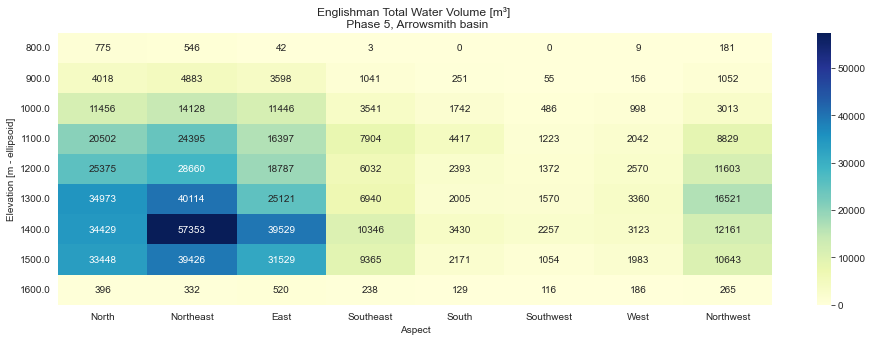

processing.. Cokely
<open Collection 'inputs/EGM_basins\cokely.shp:cokely', mode 'r' at 0x1e5333a5120>
calculating SWE..
calculating zbin table.....
calculating Aspect table.....
calculating Asp table.....


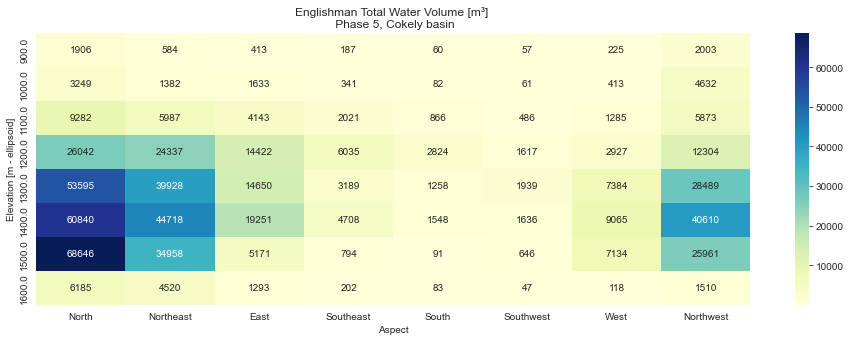

processing.. Fishtail
<open Collection 'inputs/EGM_basins\fishtail.shp:fishtail', mode 'r' at 0x1e5a1ee5540>
calculating SWE..
calculating zbin table.....
calculating Aspect table.....
calculating Asp table.....


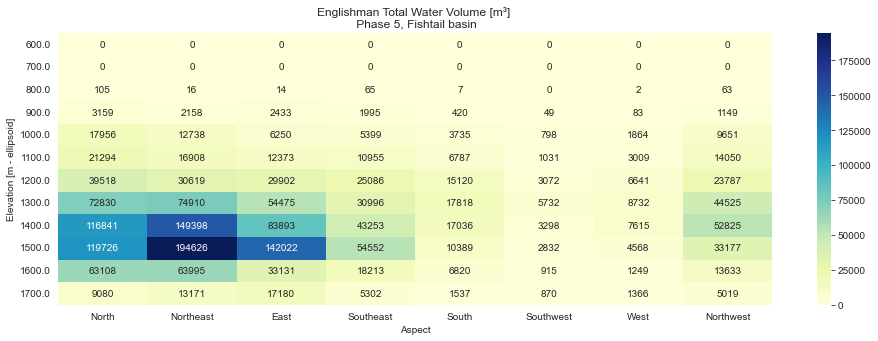

1200.0
[   0  100  200  300  400  500  600  700  800  900 1000 1100]


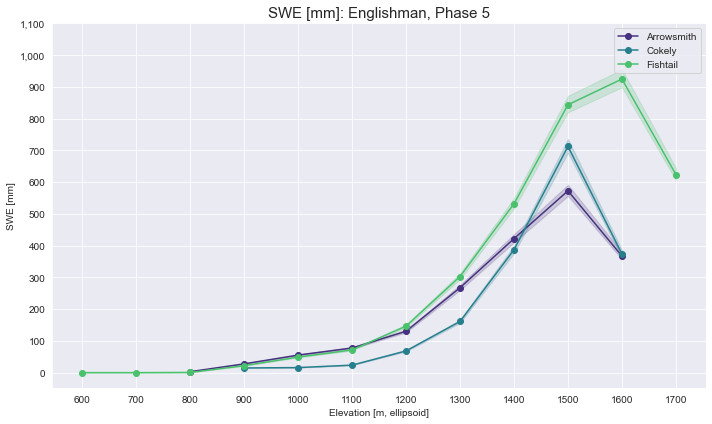

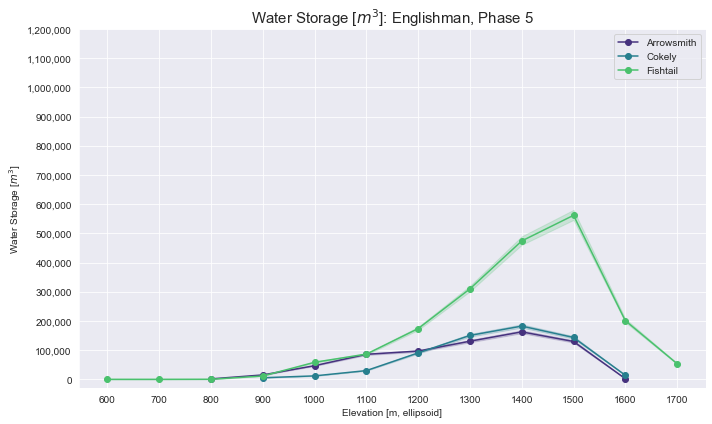

600.0
Arrowsmith
Cokely
Fishtail


13500.0
Arrowsmith
Cokely
Fishtail


In [101]:
#File loop used to iterate over the basin shapefiles and run through analysis
print("processing.." + str(watershed) + " " + str(phase))
zbin_append = []
asp_append = []

for file in os.listdir(basin_directory):
    filename = os.fsdecode(file)
    if filename.endswith(".shp"):
        #drop suffix ".shp", format for titles
        basin_name = filename[:-4].capitalize()
        
        print("processing.. " + str(basin_name))
        basin = os.path.join(basin_directory, filename)
        #create mask coordinates from the sub-basin
        mask_coords = coords(basin)
        
        #convert bare earth,aspect, and snow depth tiffs to raster array
        be_dem_ravel = open_masked_raster_array(be_directory)
        aspect_ravel = open_masked_raster_array(aspect_directory)
        snow_depth_ravel = open_masked_raster_array(snow_depth_directory)
        
        # Convert the unravelled arrays into a dataframe form
        array_df = array_to_df(be_dem_ravel,aspect_ravel,snow_depth_ravel)
        
        #calculate the swe and water volume
        swecalc_df = swe_calc(array_df,meta_df,phase)
        
        #generate binned tables for graphs
        zbin = stats("zbin", basin_name, swecalc_df,wshed,phase)
        zbin_append.append(zbin)
        aspect = stats("Aspect",basin_name, swecalc_df,wshed,phase)
        
        #This is generating aspect based on degree value for polar plot
        asp = stats("Asp", basin_name, swecalc_df,wshed,phase)
        asp_append.append(asp)
        
        #generate pivot table and heat map
        pivot_heatmap(swecalc_df,watershed,wshed,phase,basin_name)


#concanate all zbin and aspect tables for graphing, export to csv
zbin_append = pd.concat(zbin_append)
zbin_append.to_csv("outputs/{}_{}_zbin.csv".format(wshed,phase))

asp_append = pd.concat(asp_append)
asp_append.to_csv("outputs/{}_{}_asp.csv".format(wshed,phase))

#generate zbin line graph
zbin_graph(zbin_append,watershed,wshed,phase,"swe_mm","swe_hm","swe_lm",100,"SWE [mm]")
zbin_graph(zbin_append,watershed,wshed,phase,"water_vol","upper_wv","lower_wv",100,"Water Storage [$m^{3}$]")

#generate aspect polar plot
polar_plot(asp_append,"swe_mm","swe_hm","swe_lm",watershed,wshed,phase,"SWE [mm]")
polar_plot(asp_append,"water_vol","upper_wv","lower_wv",watershed,wshed,phase,"Water Storage")







### Part two: Generate temporal graphs
The scripts below are designed to be executed after phase 2 to compare water volume and SWE through the season. This generates three graph types:
1. total 

In [114]:
#append all aspect plots into one
import fnmatch

aspect = []
    
for file in os.listdir("outputs"):
    if fnmatch.fnmatch(file,"*zbin.csv"):
        file = pd.read_csv("outputs/" + file)
        aspect.append(file)

aspect = pd.concat(aspect)


        Asp  swe_mm  swe_lm  swe_hm  water_vol  lower_wv  upper_wv  count  \
0       0.0  878.38  804.41  959.28    8433.34   7723.16   9210.09   9601   
1       1.0  885.07  810.53  966.58   17077.33  15639.24  18650.25  19295   
2       2.0  889.13  814.26  971.02   17323.80  15864.95  18919.41  19484   
3       3.0  888.45  813.63  970.28   17533.52  16057.02  19148.45  19735   
4       4.0  892.70  817.52  974.92   17558.43  16079.83  19175.66  19669   
...     ...     ...     ...     ...        ...       ...       ...    ...   
1078  356.0  348.81  339.02  360.44    9787.33   9512.60  10113.57  28059   
1079  357.0  353.88  343.95  365.68   10017.68   9736.48  10351.60  28308   
1080  358.0  352.95  343.04  364.71   10159.60   9874.42  10498.25  28785   
1081  359.0  353.32  343.40  365.10   10173.49   9887.92  10512.60  28794   
1082  360.0  348.33  338.55  359.94    4999.93   4859.58   5166.60  14354   

     Phase       Basin  
0      P01  Arrowsmith  
1      P01  Arrowsmith  


C:\Users\BISHOPA\AppData\Local\Temp\ipykernel_15008\3314266426.py:10: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\BISHOPA\AppData\Local\Temp\ipykernel_15008\3314266426.py:10: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\BISHOPA\AppData\Local\Temp\ipykernel_15008\3314266426.py:10: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\BISHOPA\AppData\Local\Temp\ipykernel_15008\3314266426.py:10: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\BISHOPA\AppData\Local\Temp\ipykernel_15008\3314266426.py:10: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

[(0.0, 0.10980392156862745, 0.4980392156862745),
 (0.6941176470588235, 0.25098039215686274, 0.050980392156862744),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745),
 (0.5490196078431373, 0.03137254901960784, 0.0),
 (0.34901960784313724, 0.11764705882352941, 0.44313725490196076)]

[1, 2, 3, 4, 5]

    Phase sub_basin   water_vol    lower_wv    upper_wv
0       1         A  3603066.72  3299650.56  3934928.14
3       2         A  3888890.19  3703704.95  4000001.36
6       3         A  3439161.93  3274082.16  3569850.08
9       4         A  2145967.68  2073085.74  2214800.58
12      5         A   670955.27   652121.47   693320.45
    Phase sub_basin   water_vol    lower_wv    upper_wv
1       1         c  3724979.49  3411297.01  4068069.70
4       2         c  3912764.51  3726442.39  4024557.78
7       3         c  3500860.58  3332819.28  3633893.28
10      4         c  2319066.10  2240305.33  2393451.22
13      5         c   627848.42   610224.59   648776.69
    Phase sub_basin   water_vol    lower_wv    upper_wv
2       1         f  6212981.28  5689782.85  6785229.55
5       2         f  6557828.65  6245551.07  6745195.16
8       3         f  6230792.24  5931714.21  6467562.32
11      4         f  4161213.32  4019889.07  4294686.18
14      5         f  1930134.20  1875955.00  199

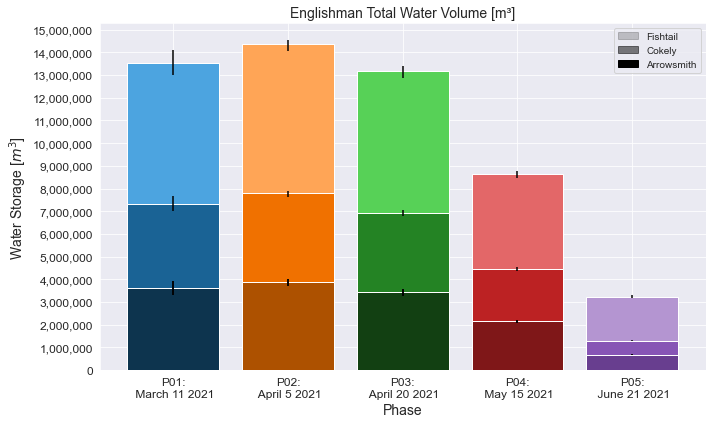

In [123]:
#combine the csvs
def combine_csv_for_total_watervolume(wshed,file_name, directory, out_directory):
    os.chdir(directory)
    # Match the pattern (‘csv’) and save the list of file names in the ‘all_filenames’ variable.
    extension = 'csv'
    df = pd.DataFrame()
    for item in glob.glob('*.{}'.format(extension)):
            file = pd.read_csv(item)
            file["sub_basin"]=item[8:9]
            df = df.append(file)
    df = df.drop_duplicates()
    df = df.groupby(by=(["Phase", "sub_basin"]), as_index=False)[["water_vol", "lower_wv", "upper_wv"]].sum()
    # export to csv
    if wshed == "Englishman":
        df.replace({"A" : "Arrowsmith", "c": "Cokely", "f": "Fishtail"}, inplace=True)
    os.chdir(out_directory)
    df.to_csv(file_name, index=False)
    return df

df = combine_csv_for_total_watervolume(wshed,"Englishman_watervol_stackedbar.csv", r"H:\Englishman\2021\Analysis\swe_tables\processing\zbin", r"H:\Englishman\2021\Analysis\swe_tables\processing\graphs")


#sns.set_style("darkgrid")
#fig, ax = plt.subplots(figsize=(10,6))
#fig.set_tight_layout(True)
color_list = sns.color_palette()[:5]
color_list_d = sns.color_palette("dark")[:5]
display(color_list_d)
#plt.bar(sum["Phase"], sum["water_vol[:5]"], color=color_list)


# Get a series of unique values in column 'Age' of the dataframe
sub_basin = df['sub_basin'].unique().tolist()
phase = df['Phase'].unique().tolist()
display(phase)

#change the dataframe to arrays from the list of water volumes
def df_to_array(df, filter_parameter, array_parameter):
    values = {}
    for i in sub_basin:
        df1=df[df[filter_parameter]==i]
        df1.sort_values(by="Phase")
        print(df1)
        basin_array = np.array(df1[array_parameter])
        values.update({i : basin_array})
    return values

def getList(dict):
      return [*dict]

#these variables hold dictionaries of the arrays
water_vol = df_to_array(df, "sub_basin", "water_vol")
lower_wv = df_to_array(df, "sub_basin", "lower_wv")
upper_wv = df_to_array(df, "sub_basin", "upper_wv")

keys = getList(water_vol)
print(water_vol)
print(keys)
print(water_vol[keys[0]])

# Get a series of unique values in column 'Age' of the dataframe
sub_basin = df['sub_basin'].unique().tolist()
phase = df['Phase'].unique().tolist()
#lighten the colour function
def lighten_color(color_list, amount=0.1):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    values = []
    import matplotlib.colors as mc
    import colorsys
    for color in color_list:
        try:
            c = mc.cnames[color]
        except:
            c = color
            c = colorsys.rgb_to_hls(*mc.to_rgb(c))
        
        item = colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
        values.append(item)
    return values

color_list = lighten_color(sns.color_palette()[:5],1.4) #darken the standard seaborne color list

#change the dataframe to arrays from the list of water volumes
def df_to_array(df, filter_parameter, array_parameter):
    values = {}
    for i in sub_basin:
        df1=df[df[filter_parameter]==i]
        df1.sort_values(by="Phase")
        print(df1)
        basin_array = np.array(df1[array_parameter])
        values.update({i : basin_array})
    return values

def getList(dict):
      return [*dict]

#these variables hold dictionaries of the arrays
water_vol = df_to_array(df, "sub_basin", "water_vol")
lower_wv = df_to_array(df, "sub_basin", "lower_wv")
upper_wv = df_to_array(df, "sub_basin", "upper_wv")

keys = getList(water_vol)

sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(10,6))
fig.set_tight_layout(True)



#graph the first basin in the list first
plt.bar(phase, water_vol[keys[0]], color=color_list)
plt.vlines(phase, lower_wv[keys[0]], upper_wv[keys[0]], color="black")

#loop through the sub-basins 
loop = 0
bottom = water_vol[keys[0]]
amount = .8

for key in water_vol:
    print(key)
    if loop == 0:
        plt.bar(phase, bottom, color=color_list)
        plt.vlines(phase, lower_wv[keys[0]], upper_wv[keys[0]], color="black")
        loop = loop + 1
    else:
        add = water_vol[keys[loop]] #find the amount to add
        add_ue = upper_wv[keys[loop]] + bottom
        add_le = lower_wv[keys[loop]] + bottom
        plt.bar(phase, add, color=lighten_color(color_list,amount), bottom=bottom)
        plt.vlines(phase, add_le, add_ue, "black")
        bottom = bottom + add #add the amount to the bottom of the bars
        loop = loop + 1
        amount = amount - .3 #change the hue

ax.set_ylabel("Water Storage [$m^{3}$]", fontsize=14)
ax.set_xlabel("Phase", fontsize=14)
labels2021 = ["P01:\n March 11 2021", "P02:\n April 5 2021", "P03:\n April 20 2021", "P04:\n May 15 2021", "P05:\n June 21 2021"]

plt.xticks([1,2,3,4,5], fontsize=12)
ax.set_xticklabels(labels2021)

plt.yticks(np.arange(0, 15500000, step=1000000),fontsize=12)
EGM_yticklabels = ["0","1,000,000", "2,000,000", "3,000,000","4,000,000", "5,000,000", "6,000,000","7,000,000","8,000,000","9,000,000","10,000,000","11,000,000","12,000,000","13,000,000","14,000,000", "15,000,000"]
ax.set_yticklabels(EGM_yticklabels)
#legend
# Fishtail top - 0.5 alpha
#cokely middle - 0.7 alpha
# arrowsmith top - 1 alpha
import matplotlib.patches as mpatches
light = mpatches.Patch(color = "Black", alpha = 0.2, label = "Fishtail" )
mid = mpatches.Patch(color = "Black", alpha = 0.5, label = "Cokely" )
dark = mpatches.Patch(color = "Black", alpha = 1, label = "Arrowsmith" )

ax.legend(handles=[light, mid,dark])


plt.title("Englishman Total Water Volume [m\u00b3]", fontsize = 14) 
plt.savefig("H:\Working Folders\Ali\jupyter\geog650\outputs\stackedbars_wvol_EGM.png", dpi=300)
    
    

plt.show()

In [120]:
#Graphs for SWE line plot by aspect using plotly
#define colours

pal = sns.color_palette()
clist = pal.as_hex()

#hex to rgb testing
import matplotlib.colors as colors

def hex_to_rgb(clist):
    #converting seaborne colors to hex value
    rgb_list = []
    new_list = []
    #converting the list of hex values to rgb - this changes decimal to number
    for h in clist:
        rgb = colors.hex2color(h)
        color = list([int(255*x) for x in rgb])
    #this line is appending a transparency value
        color.append(0.3)
        tuplecolor = tuple(color)
        rgb_list.append(tuplecolor)
    
    for x in rgb_list:
        new_list.append("rgba" + str(x))
    return(new_list)

color_error = hex_to_rgb(clist) #need to input a list of hex values here

display(color_error[2])
#rgb(31,119,180,0.5)

dates = ["P01: March 11 2021", "P02: April 5 2021", "P03: April 20 2021", "P04: May 15 2021", "P05: June 21 2021"]

def wv_aspect_polar_line(df,wshed,basin_name,dates,clist,color_error):
    sns.set_style("darkgrid")
    
    df["Asp"].replace({0: 360}, inplace=True)
    
    avg_swe = round(df.groupby(by=["Asp", "Phase"],as_index=True)[["swe_mm","swe_lm", "swe_hm"]].mean(),2)
    avg_wv = round(df.groupby(by=["Asp", "Phase"],as_index=True)[["water_vol", "lower_wv", "upper_wv"]].sum(),2)
    df=pd.concat([avg_swe,avg_wv],axis=1)
    df = df.reset_index(drop=False)
    print(df)
    df = df[df["Asp"]>=0] #This removes the flat areas from graph

    
    #variables per each phase
    p01 = df[df["Phase"]=="P01"]
    p02 = df[df["Phase"]=="P02"]
    p03 = df[df["Phase"]=="P03"]
    p04 = df[df["Phase"]=="P04"]
    p05 = df[df["Phase"]=="P05"]


    #This is a great hack to convert the sns color palette to plotly
    pal = sns.color_palette()
    clist = pal.as_hex()
    title = "SWE [mm] by Aspect: " + watershed + " basin"
    swe_max = round((p02["swe_hm"].max()+100),-2)
    print(swe_max)

    #set the layout parameters for figure
    layout = go.Layout(polar=dict(
    angularaxis = dict(thetaunit="degrees",
            dtick=45,
             rotation=90,
             direction='clockwise',
             tickmode="array",
             tickvals=[0, 45, 90, 135, 180, 225, 270, 315],
             ticktext=["N", "NE", "E", "SE", "S", "SW", "W", "NW"])
         ,radialaxis=dict(range=[1,swe_max]))
     )

    fig = go.Figure(layout=layout)

    fig.update_layout(
    title={
        'text': title,
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

    def add_trace(phase, color_number, name):
        fig.add_trace(go.Scatterpolar(
                     r = phase['swe_hm'],
                     theta = phase['Asp'],
                     mode = "lines",
                    showlegend=False,
                     line_color = color_error[color_number]
            ))
        fig.add_trace(go.Scatterpolar(
            r = phase['swe_mm'],
            theta = phase['Asp'],
            mode = 'lines',
            fill="tonext",
            name=name,
            line_color = clist[color_number]
            ))
                      
        fig.add_trace(go.Scatterpolar(
            r = phase['swe_lm'],
            theta = phase['Asp'],
            mode = 'none',
            fill="tonext",
            showlegend=False,
            fillcolor = color_error[color_number]
            )
                    )

    
    #call functions  to add lines to graph
    phase1 = add_trace(p01,0, dates[0])
    phase2 = add_trace(p02,1, dates[1])
    phase3=add_trace(p03,2,dates[2])
    phase4=add_trace(p04,3,dates[3])
    phase5=add_trace(p05,4,dates[4])
    
    #Add errpr bars to graph
    
    fig.show()
    fig.write_image("outputs/" + wshed + "polar_total_swemm.png")

wv_aspect_polar_line(aspect,wshed,basin_name,dates,clist,color_error)

'rgba(44, 160, 44, 0.3)'

        Asp Phase  swe_mm  swe_lm  swe_hm  water_vol  lower_wv  upper_wv
0       1.0   P01  852.01  780.26  930.48   63637.60  58278.65  69498.97
1       1.0   P02  895.06  852.43  920.63   66665.69  63491.13  68570.43
2       1.0   P03  812.32  773.33  843.19   60787.67  57869.87  63097.60
3       1.0   P04  629.56  608.18  649.75   47489.89  45877.03  49013.15
4       1.0   P05  249.27  242.27  257.58   19609.31  19058.87  20262.94
...     ...   ...     ...     ...     ...        ...       ...       ...
1795  360.0   P01  854.59  782.63  933.31   64005.84  58615.87  69901.12
1796  360.0   P02  897.56  854.82  923.20   67052.29  63859.32  68968.07
1797  360.0   P03  815.14  776.01  846.12   61158.57  58222.96  63482.58
1798  360.0   P04  632.44  610.96  652.73   47816.47  46192.52  49350.21
1799  360.0   P05  248.13  241.17  256.40   19511.63  18963.92  20162.02

[1800 rows x 8 columns]
1100.0


In [ ]:
#Graphs for SWE line plot by aspect using plotly
#define colours

pal = sns.color_palette()
clist = pal.as_hex()

#hex to rgb testing
import matplotlib.colors as colors

def hex_to_rgb(clist):
    #converting seaborne colors to hex value
    rgb_list = []
    new_list = []
    #converting the list of hex values to rgb - this changes decimal to number
    for h in clist:
        rgb = colors.hex2color(h)
        color = list([int(255*x) for x in rgb])
    #this line is appending a transparency value
        color.append(0.3)
        tuplecolor = tuple(color)
        rgb_list.append(tuplecolor)
    
    for x in rgb_list:
        new_list.append("rgba" + str(x))
    return(new_list)

color_error = hex_to_rgb(clist) #need to input a list of hex values here

display(color_error[2])
#rgb(31,119,180,0.5)

dates = ["P01: March 11 2021", "P02: April 5 2021", "P03: April 20 2021", "P04: May 15 2021", "P05: June 21 2021"]

def wv_aspect_polar_line(df,wshed,basin_name,dates,clist,color_error):
    sns.set_style("darkgrid")
    
    df["Asp"].replace({0: 360}, inplace=True)
    
    avg_swe = round(df.groupby(by=["Asp", "Phase"],as_index=True)[["swe_mm","swe_lm", "swe_hm"]].mean(),2)
    avg_wv = round(df.groupby(by=["Asp", "Phase"],as_index=True)[["water_vol", "lower_wv", "upper_wv"]].sum(),2)
    df=pd.concat([avg_swe,avg_wv],axis=1)
    df = df.reset_index(drop=False)
    print(df)
    df = df[df["Asp"]>=0] #This removes the flat areas from graph

    
    #variables per each phase
    p01 = df[df["Phase"]=="P01"]
    p02 = df[df["Phase"]=="P02"]
    p03 = df[df["Phase"]=="P03"]
    p04 = df[df["Phase"]=="P04"]
    p05 = df[df["Phase"]=="P05"]


    #This is a great hack to convert the sns color palette to plotly
    pal = sns.color_palette()
    clist = pal.as_hex()
    title = "Water Volume by Aspect: " + watershed + " basin"
    swe_max = round((p02["upper_wv"].max()+100),-2)
    print(swe_max)

    #set the layout parameters for figure
    layout = go.Layout(polar=dict(
    angularaxis = dict(thetaunit="degrees",
            dtick=45,
             rotation=90,
             direction='clockwise',
             tickmode="array",
             tickvals=[0, 45, 90, 135, 180, 225, 270, 315],
             ticktext=["N", "NE", "E", "SE", "S", "SW", "W", "NW"])
         ,radialaxis=dict(range=[1,swe_max]))
     )

    fig = go.Figure(layout=layout)

    fig.update_layout(
    title={
        'text': title,
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

    def add_trace(phase, color_number, name):
        fig.add_trace(go.Scatterpolar(
                     r = phase['upper_wv'],
                     theta = phase['Asp'],
                     mode = "lines",
                    showlegend=False,
                     line_color = color_error[color_number]
            ))
        fig.add_trace(go.Scatterpolar(
            r = phase['water_vol'],
            theta = phase['Asp'],
            mode = 'lines',
            fill="tonext",
            name=name,
            line_color = clist[color_number]
            ))
                      
        fig.add_trace(go.Scatterpolar(
            r = phase['lower_wv'],
            theta = phase['Asp'],
            mode = 'none',
            fill="tonext",
            showlegend=False,
            fillcolor = color_error[color_number]
            )
                    )

    
    #call functions  to add lines to graph
    phase1 = add_trace(p01,0, dates[0])
    phase2 = add_trace(p02,1, dates[1])
    phase3=add_trace(p03,2,dates[2])
    phase4=add_trace(p04,3,dates[3])
    phase5=add_trace(p05,4,dates[4])
    
    #Add errpr bars to graph
    
    fig.show()
    fig.write_image("outputs/" + wshed + "polar_total_watervol.png")

wv_aspect_polar_line(aspect,wshed,basin_name,dates,clist,color_error)